# ***Tarea 5. Modelos de clasificación***
### Luis Eduardo Jiménez del Muro - 04/03/2025
---

# Paqueterías y funciones

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import neighbors
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import discriminant_analysis
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
# Calibracion
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False) + 1
    grouped = df_calibracion.groupby('bins').mean()
    auc = roc_auc_score(y_score=predicciones, y_true=y)
    
    # Gráfica
    plt.figure(figsize=(8,6))
    plt.plot(grouped['predicciones'], grouped['predicciones'], label='Real', color='red', lw=1.5)
    plt.plot(grouped['predicciones'], grouped['y'], label='Modelo', marker='o', color='cadetblue', ms=5, lw=2)
    plt.title(f'Calibración del modelo \n\n$AUC={auc:.4f}$')
    plt.grid(alpha=0.3)
    plt.legend()

# Histograma
def histograma(probabilidades, y):
    resultados = pd.DataFrame({'y':y, 'probabilidades': probabilidades})
    plt.figure(figsize=(8,6))
    sns.histplot(resultados[resultados['y'] == 1]['probabilidades'], color='cadetblue', alpha=0.5, kde=True, bins=20, edgecolor=None, label='1')
    sns.histplot(resultados[resultados['y'] == 0]['probabilidades'], color='seagreen', alpha=0.5, kde=True, bins=20, edgecolor=None, label='0')
    plt.title('Histograma de probabilidades', fontsize=16)
    plt.legend(loc='best')
    plt.xlabel('Probabilidades')
    plt.ylabel('Frecuencia')
    plt.grid(alpha=0.3)
    plt.show()

# ROC Curve
def roc_curve_graph(probabilidades, y):
    fpr, fpn, scores = roc_curve(y_score=probabilidades, y_true=y)
    plt.figure(figsize=(8,6))
    plt.title('ROC Curve', fontsize=16)
    plt.plot(fpr, fpn, label='Modelo', color='cadetblue', lw=2)
    plt.plot([0, 1], [0, 1], label='Real', color='red', lw=1.5)
    plt.xlabel("1-specificty")
    plt.ylabel("sensitivity")
    plt.legend(loc='best')
    plt.grid(alpha=0.3)

# Plotear resultados
def plot_results(probabilidades, y, bins):
    calibracion(probabilidades, y, bins)
    histograma(probabilidades, y)
    roc_curve_graph(probabilidades, y)

# Logistica Grado 2
def logistic_poly(X_train, y_train, X_test, degree):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly_features', PolynomialFeatures(degree=degree)),
        ('model', linear_model.LogisticRegression(penalty='l2'))
    ])

    pipeline.fit(X_train, y_train)
    probabilidades_logistic_poly = pipeline.predict_proba(X_test)[:,1]
    return probabilidades_logistic_poly

# Modelo KNN
def knn(X_train, y_train, X_test, n_neighbors):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = neighbors.KNeighborsClassifier(n_neighbors=99).fit(X_train_scaled, y_train)
    probabilidades_knn = model.predict_proba(X_test_scaled)[:,1]
    return probabilidades_knn

# Graficar AUC por cada vecino
def graph_knn(X_train, y_train, X_test, y_test, n_neighbors):
    vecinos = []
    auc = []

    # Escalado de datos
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for i in range(1, n_neighbors):
        model = neighbors.KNeighborsClassifier(n_neighbors=i).fit(X_train_scaled, y_train)
        probabilidades = model.predict_proba(X_test_scaled)[:,1]
        vecinos.append(i)
        auc.append(roc_auc_score(y_score=probabilidades, y_true=y_test))

    resultados = pd.DataFrame({'nn':vecinos, 'auc': auc})
    max_auc = resultados[resultados['auc'] == resultados.max()['auc']][['nn', 'auc']]

    plt.figure(figsize=(8,6))
    plt.title(f'Número de vecinos óptimo = {max_auc["nn"].values[0]:.4f}', fontsize=16)
    plt.plot(resultados['nn'], resultados['auc'], color='cadetblue',lw=1.5, marker='o', ms=3, label='Otros Puntos')
    plt.scatter(max_auc['nn'], max_auc['auc'], marker='*', color='red',zorder=2, s=50, label='Max AUC')
    plt.grid(alpha=0.3)
    plt.ylabel('AUC')
    plt.xlabel('Número de Vecinos')
    plt.legend(loc='best')
    plt.show()

# Preparación de los datos

In [3]:
target = 'Diagnosis'

df = pd.read_csv('data/alzheimers_disease_data.csv')
df.nunique()

PatientID                    2149
Age                            31
Gender                          2
Ethnicity                       4
EducationLevel                  4
BMI                          2149
Smoking                         2
AlcoholConsumption           2149
PhysicalActivity             2149
DietQuality                  2149
SleepQuality                 2149
FamilyHistoryAlzheimers         2
CardiovascularDisease           2
Diabetes                        2
Depression                      2
HeadInjury                      2
Hypertension                    2
SystolicBP                     90
DiastolicBP                    60
CholesterolTotal             2149
CholesterolLDL               2149
CholesterolHDL               2149
CholesterolTriglycerides     2149
MMSE                         2149
FunctionalAssessment         2149
MemoryComplaints                2
BehavioralProblems              2
ADL                          2149
Confusion                       2
Disorientation

In [4]:
df = df.drop(columns=['PatientID', 'DoctorInCharge'])
df = pd.get_dummies(df, columns=['Ethnicity', 'EducationLevel'])
df.head()

,Age,Gender,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryAlzheimers,CardiovascularDisease,...,Forgetfulness,Diagnosis,Ethnicity_0,Ethnicity_1,Ethnicity_2,Ethnicity_3,EducationLevel_0,EducationLevel_1,EducationLevel_2,EducationLevel_3
0,73,0,22.927749,0,13.297218,6.327112,1.347214,9.025679,0,0,...,0,0,True,False,False,False,False,False,True,False
1,89,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,0,0,...,1,0,True,False,False,False,True,False,False,False
2,73,0,17.795882,0,19.555085,7.844988,1.826335,9.673574,1,0,...,0,0,False,False,False,True,False,True,False,False
3,74,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,0,0,...,0,0,True,False,False,False,False,True,False,False
4,89,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,0,0,...,0,0,True,False,False,False,True,False,False,False


In [5]:
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 1. Regresión Logística

### Coeficientes

In [6]:
model = linear_model.LogisticRegression()
model.fit(X_train, y_train)
probabilidades_logistic = model.predict_proba(X_test)[:, 1]
coeficientes = pd.DataFrame({'Feature':df.drop(target, axis=1).columns, 'Coeficiente':model.coef_[0]})
coeficientes

,Feature,Coeficiente
0,Age,0.017188
1,Gender,0.134669
2,BMI,-0.018778
3,Smoking,-0.017399
4,AlcoholConsumption,-0.041068
5,PhysicalActivity,-0.029835
6,DietQuality,0.068909
7,SleepQuality,-0.095295
8,FamilyHistoryAlzheimers,-0.023923
9,CardiovascularDisease,0.066150


### Conclusiones de los coeficientes

### Ajuste del Modelo

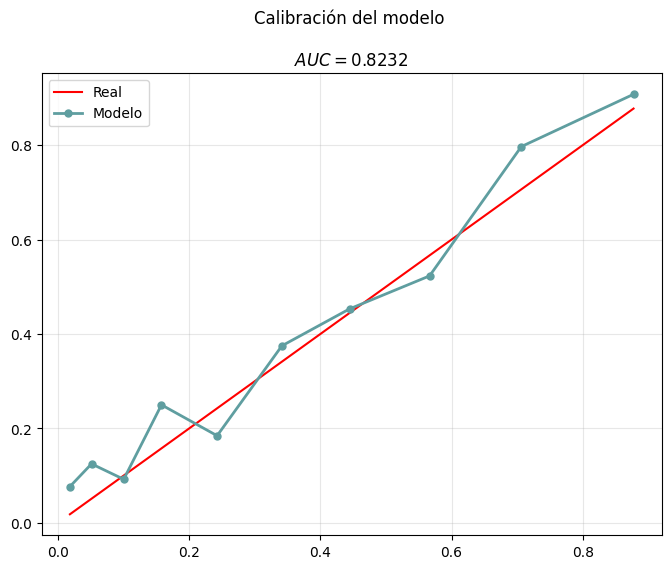

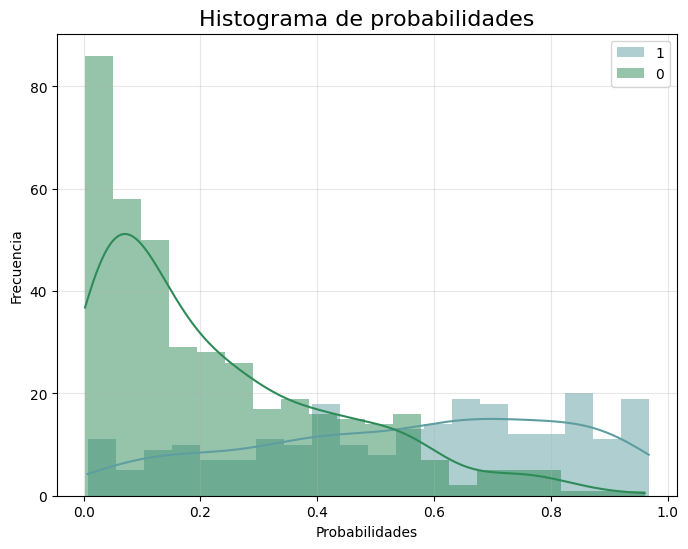

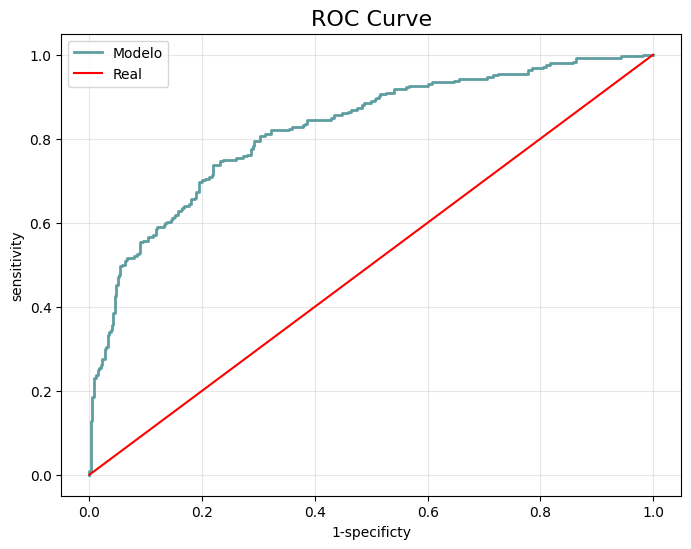

In [7]:
plot_results(probabilidades_logistic, y_test, 10)

# Polinomial grado 2

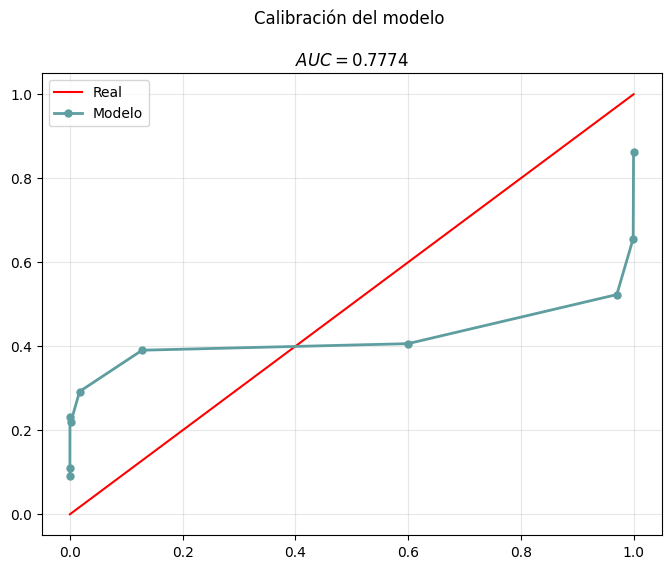

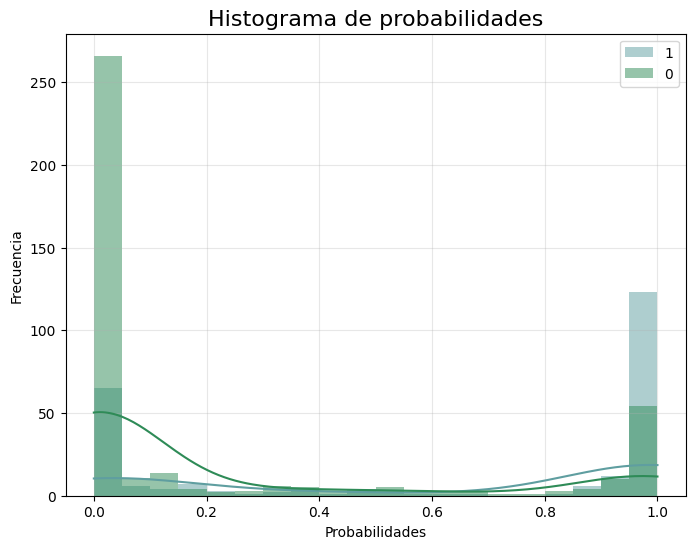

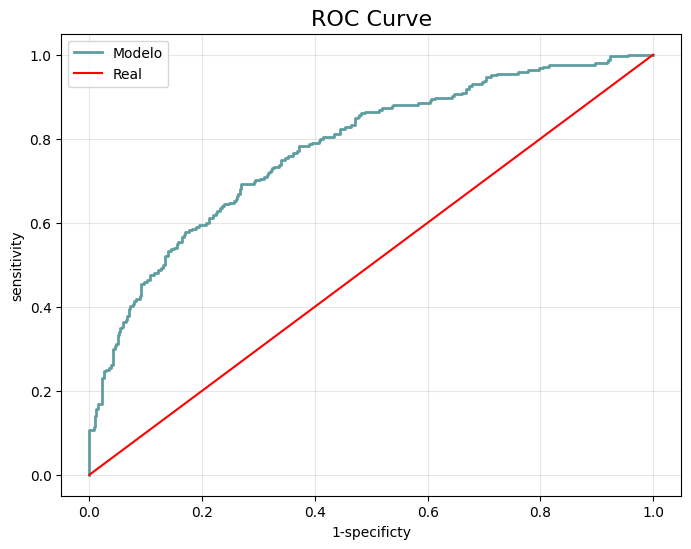

In [8]:
probabilidades_logistic_2 = logistic_poly(X_train, y_train, X_test, 2)
plot_results(probabilidades_logistic_2, y_test, 10)

# Polinomial grado 3

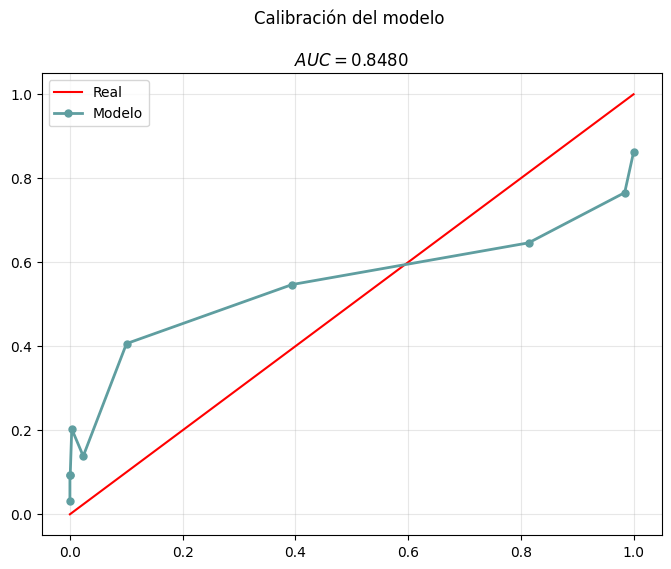

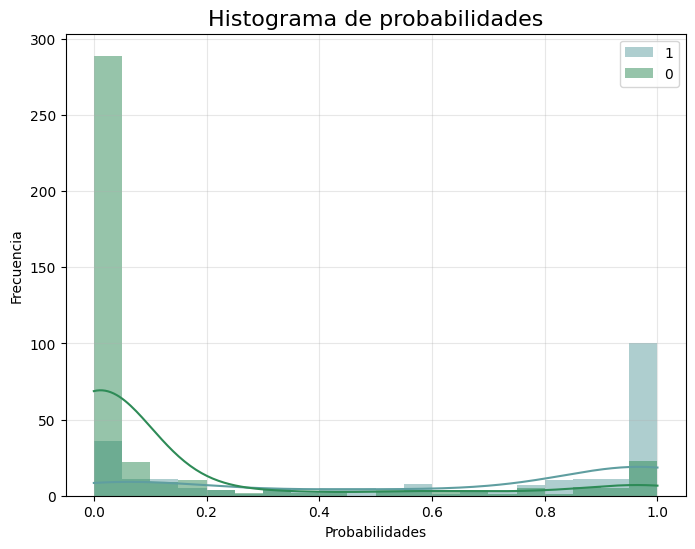

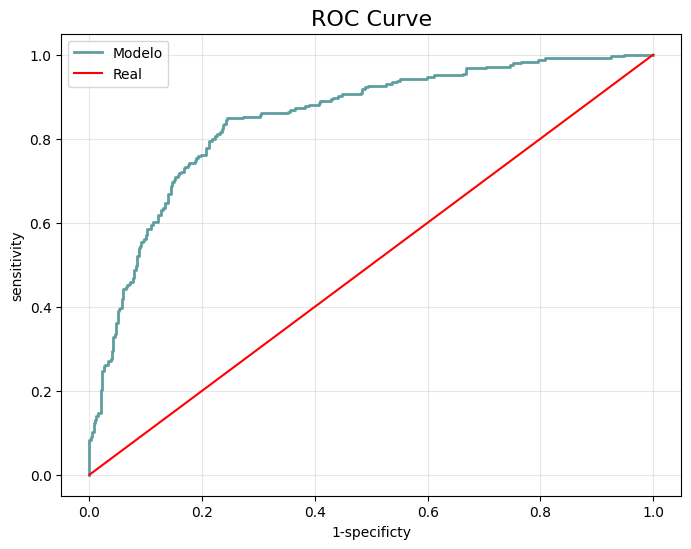

In [9]:
probabilidades_logistic_3 = logistic_poly(X_train, y_train, X_test, 3)
plot_results(probabilidades_logistic_3, y_test, 10)

# KNN

### Obtener el número óptimo de vecinos

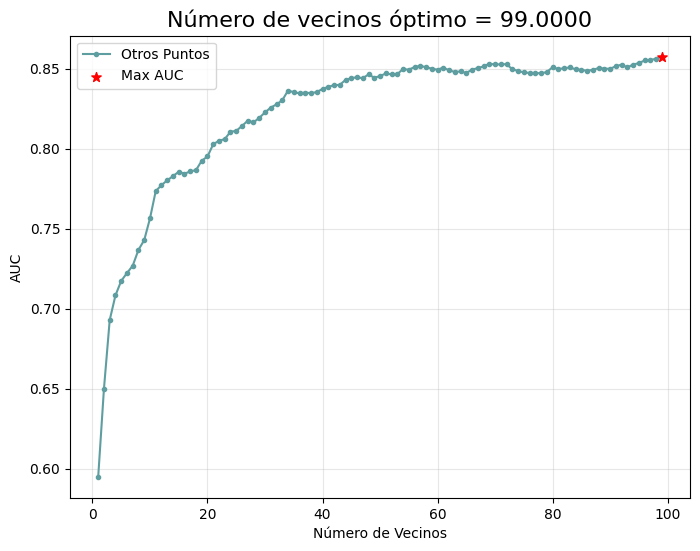

In [10]:
graph_knn(X_train, y_train, X_test, y_test, 100)

### Resultados KNN

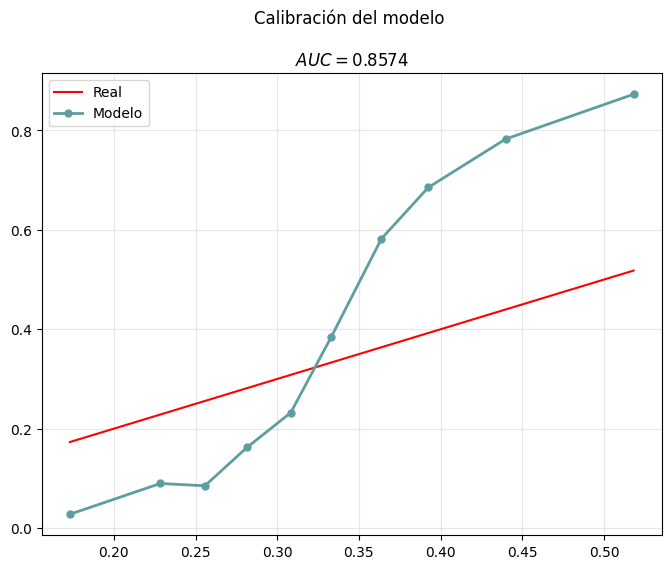

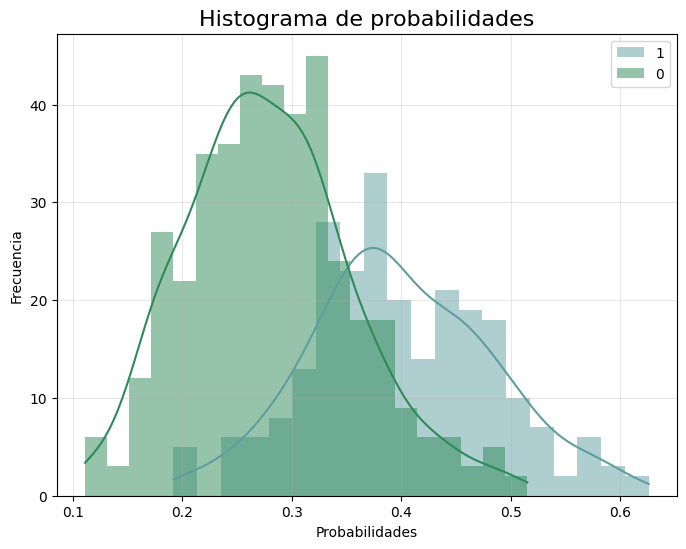

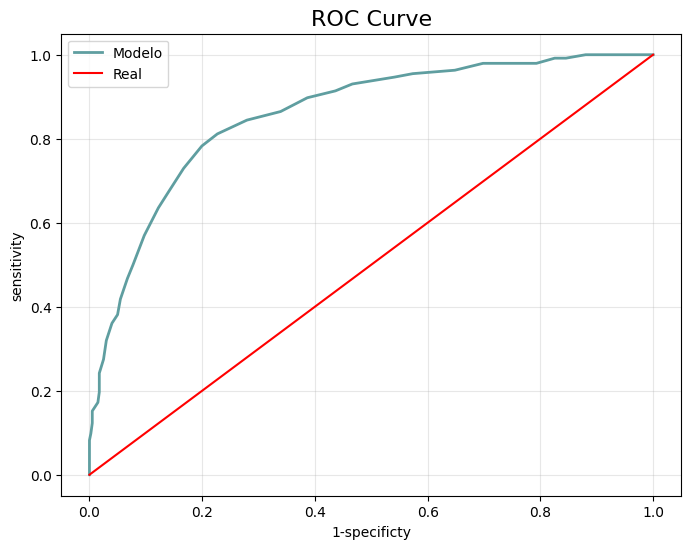

In [11]:
probabilidades_knn = knn(X_train, y_train, X_test, 99)
plot_results(probabilidades_knn, y_test, 10)

# Análisis del discriminante lineal

In [12]:
def linear_discriminant_analysis(X_train, y_train, X_test):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', discriminant_analysis.LinearDiscriminantAnalysis())
    ])

    pipeline.fit(X_train, y_train)
    probabilidades_modelo_disc = pipeline.predict_proba(X_test)[:,1]
    return probabilidades_modelo_disc

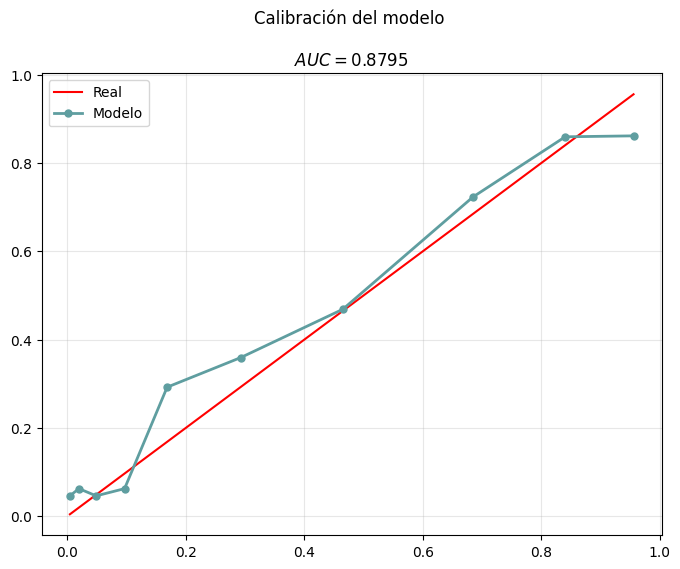

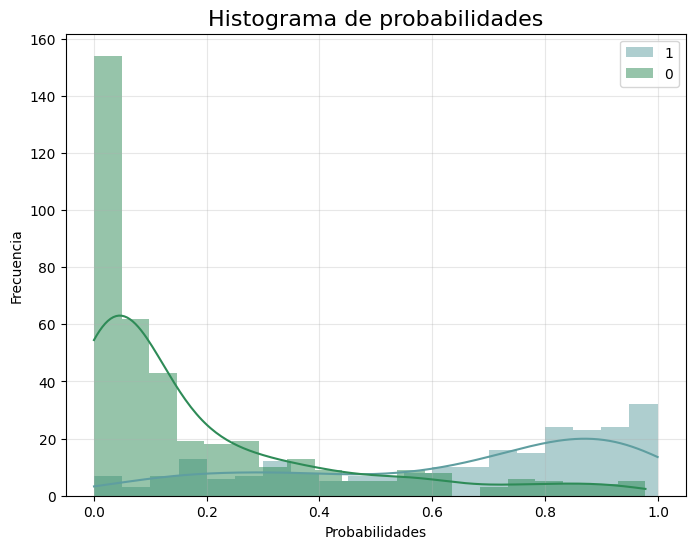

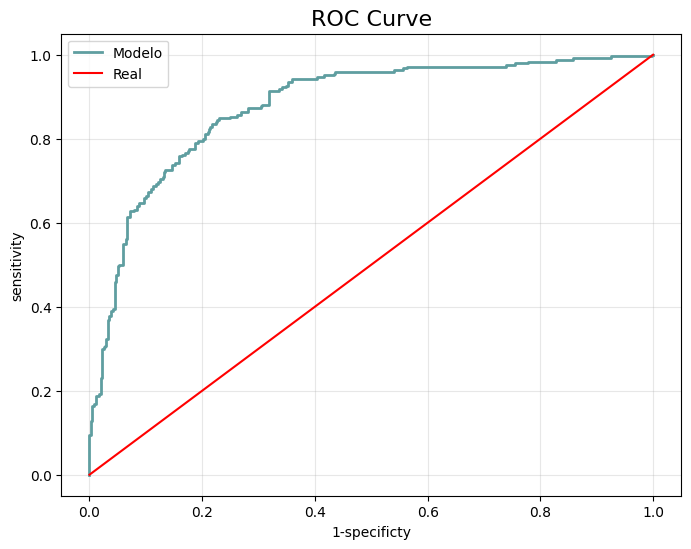

In [13]:
probabilidades_discriminant = linear_discriminant_analysis(X_train, y_train, X_test)
plot_results(probabilidades_discriminant, y_test, 10)

# Conclusión

### Resumen de resultados de todos los modelos. Calcular gini para ver el ajuste entre 0 y 1

In [14]:
model_summary = pd.DataFrame({
    'Model': [
        'Logistic Regresion', 'Logistic Regresion poly 2', 'Logistic Regresion poly 3', 'KNN', 'Discriminant'
    ],
    'AUC': [
        roc_auc_score(y_score=probabilidades_logistic, y_true=y_test),
        roc_auc_score(y_score=probabilidades_logistic_2, y_true=y_test),
        roc_auc_score(y_score=probabilidades_logistic_3, y_true=y_test),
        roc_auc_score(y_score=probabilidades_knn, y_true=y_test),
        roc_auc_score(y_score=probabilidades_discriminant, y_true=y_test)
    ]
})
model_summary['Gini'] = 2 * model_summary['AUC'] - 1
model_summary.round(4)

,Model,AUC,Gini
0,Logistic Regresion,0.8232,0.6465
1,Logistic Regresion poly 2,0.7774,0.5549
2,Logistic Regresion poly 3,0.8480,0.6961
3,KNN,0.8574,0.7148
4,Discriminant,0.8795,0.7591
